In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd

In [4]:
X = pd.read_csv("/home/dsi/zuckerm1/r_files/All_Samples/data_fs_600.csv", index_col = 0)

In [5]:
X.head(2)

,CAVNTNAGKSTF,CAVNTGGFKTIF,CAVNTGNQFYF,CAENSGGSNYKLTF,CAVRDGDYKLSF,CAASGGSNYKLTF,CAVNQAGTALIF,CAVNSGGYQKVTF,CAENTGGFKTIF,CAVNRDDKIIF,...,CASSLVNEQFF,CASSTSTDTQYF,CASSVGGNTEAFF,CASSPGYEQYF,CAVSKAAGNKLTF,CALAGGTSYGKLTF,CASSLGTSTDTQYF,CAVPNDYKLSF,CAVVDSNYQLIW,y
1_A_B_H,0.000081,0.000121,0.00004,0.000161,0.000403,0.00000,0.000081,0.00004,0.00004,0.000000,...,0.0,0.000000,0.0,0.000161,0.0,0.0,0.0,0.0,0.0,0
1_A_B_OC,0.000000,0.000121,0.00000,0.000040,0.000282,0.00004,0.000040,0.00000,0.00000,0.000081,...,0.0,0.000081,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1


In [5]:
X.shape

(95, 601)

In [6]:
# select 10 top features chosen by SFM XGB 
features = ['CVVSDRGSTLGRLYF',
 'CAVNFGNEKLTF',
 'CASSLGGNTEAFF',
 'CAVNNAGNMLTF',
 'CAGAGGTSYGKLTF',
 'CASSLTGELFF',
 'CAVRDSNYQLIW',
 'CASSLGYNEQFF',
 'CASSLARNTEAFF',
 'CASSLVNEQFF',
 'y']

In [8]:
X = X[features]

In [17]:
X.head(2)

,CVVSDRGSTLGRLYF,CAVNFGNEKLTF,CASSLGGNTEAFF,CAVNNAGNMLTF,CAGAGGTSYGKLTF,CASSLTGELFF,CAVRDSNYQLIW,CASSLGYNEQFF,CASSLARNTEAFF,CASSLVNEQFF,y
1_A_B_H,0.000121,0.00000,0.00000,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.0,0
1_A_B_OC,0.000121,0.00004,0.00004,0.000081,0.0,0.00004,0.00004,0.0,0.0,0.0,1


In [ ]:
from atom import ATOMClassifier

In [1]:
import numpy as np
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import roc_auc_score, auc, roc_curve
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random
from scipy import interp

Create ROC

1
<< ================== ATOM ================== >>
Algorithm task: binary classification.

Dataset stats ==================== >>
Shape: (95, 11)
Memory: 8.49 kB
Scaled: False
Outlier values: 16 (2.0%)
Duplicate samples: 4 (4.2%)
-------------------------------------
Train set size: 72
Test set size: 23
-------------------------------------
|   |    dataset |      train |       test |
| - | ---------- | ---------- | ---------- |
| 0 |   49 (1.1) |   37 (1.1) |   12 (1.1) |
| 1 |   46 (1.0) |   35 (1.0) |   11 (1.0) |


Training ========================= >>
Models: LDA
Metric: roc_auc


Running BO for Linear Discriminant Analysis...
| call             |  solver | shrinkage | roc_auc | best_roc_auc |    time | total_time |
| ---------------- | ------- | --------- | ------- | ------------ | ------- | ---------- |
| Initial point 1  |   eigen |       1.0 |  0.8642 |       0.8642 |  0.014s |     0.026s |
| Initial point 2  |     svd |       --- |   0.963 |        0.963 |  0.016s |     2.348s

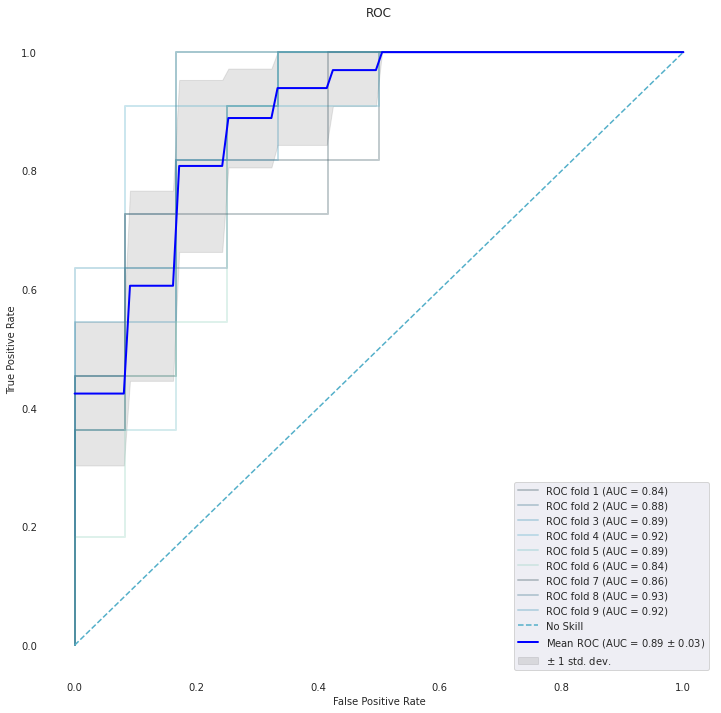

In [11]:
fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111)


tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

for x in range(1,10):
    print(x)
    atom_2 = ATOMClassifier(X, y="y", test_size=(23/95), verbose=2, warnings=False, random_state = x)
    atom_2.run(models=[ "LDA"], 
         n_calls=50,
         n_initial_points=10,
         metric="AUC",
         n_bootstrap=5)

    # keep probabilities for the positive outcome only
    yhat = atom_2.winner.predict_proba_test[:, 1]
    # calculate roc curves
    fpr, tpr, threshold = roc_curve(atom_2.y_test, yhat)
    tprs.append(interp(mean_fpr, fpr, tpr))
    auc_score = roc_auc_score(atom_2.y_test, yhat)
    aucs.append(auc_score)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (x, auc_score))


plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, lw=2, alpha=1, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))

std_tpr = np.std(tprs, axis=0)
tprs_lower = mean_tpr - std_tpr
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.",)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC')
ax.legend()
ax.set_facecolor('w')
plt.show()

fig.savefig("ROCs.pdf")